In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import f1_score
from keras.utils import to_categorical
from keras import optimizers
from keras import regularizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras.regularizers import l2
from keras import layers
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU, Bidirectional 
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from tqdm import tqdm
from langua import Predict
import gensim
import time
import re

Using TensorFlow backend.


# Data Preparation & Exploration:

In [2]:
# Load data to pandas df:
df = pd.DataFrame.from_csv('exportESP1M.csv', encoding='utf-8')

In [3]:
#Drop unnecessary columns
df.drop(['tx_id', 'author', 'parent_author', 'timestamp', 'json_metadata', 
         'title', 'title', 'lang'], axis=1, inplace = True, errors='ignore')

In [4]:
df

,body,words_pos_polarity,words_neg_polarity,emoji_pos_polarity,emoji_neg_polarity,word_emoji_pos_pol_diff,word_emoji_neg_pol_diff,label
0,Abit is no spammer,0.000000,-0.200000,0.0,0.0,0.0,0.0,0.0
1,You da man,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,B vs S,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,URL Como ya sabéis Aniestudio esta en una con...,0.588500,-0.477500,0.0,0.0,0.0,0.0,1.0
4,Hace días que no puedo perder un rato en una g...,0.512667,-0.421667,0.0,0.0,0.0,0.0,1.0
5,El halving e acerca y con el las expectativas ...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
6,Espero pasarla muy bien en este sitio conocer...,0.841500,-0.200000,0.0,0.0,0.0,0.0,1.0
7,info quien desea trabajar desde su casa,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
8,información. Quien quiere trabajar desde casa,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
9,Quiero que alguien me explique como funciona r...,0.321500,0.000000,0.0,0.0,0.0,0.0,0.0


### Label Distribution:

-1 = Negative sentiment,
 0 = No sentiment,
 1 = Positive sentiment

In [5]:
df.label.value_counts()

 0.0    5643
 1.0    2099
-1.0     401
Name: label, dtype: int64

## Data Description:

In [7]:
df.describe()

,words_pos_polarity,words_neg_polarity,emoji_pos_polarity,emoji_neg_polarity,word_emoji_pos_pol_diff,word_emoji_neg_pol_diff,label
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,0.162196,-0.064786,0.045561,-0.002210,0.035734,0.001854,0.208523
std,0.258237,0.153083,0.208543,0.046967,0.173672,0.040255,0.513384
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.330000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000


### Train Test Split

In [163]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## TF-IDF Vectorizer:

In [95]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train.body)
X_train.shape

/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(6107, 6977)

In [17]:
X_test = vectorizer.transform(X_test.body)
X_test.shape

/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(2036, 6977)

# MACHINE LEARNING ALGORITHMS:

## NAIVE BAYES:

In [25]:
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)

GaussianNB(priors=None)

In [26]:
score = gnb.score(X_test.toarray(), y_test)
print('Model Accuracy:', (score*100), '%')

Model Accuracy: 68.95874263261297 %


In [27]:
predicted = gnb.predict(X_test.toarray())
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

         -1       0.11      0.39      0.17       124
          0       0.92      0.75      0.83      1393
          1       0.68      0.60      0.64       519

avg / total       0.81      0.69      0.74      2036



## LOGISTIC REGRESSION:

In [18]:
model = LogisticRegression(multi_class='ovr')

In [19]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
score = model.score(X_test, y_test)
print('Model Accuracy:', (score*100), '%')

Model Accuracy: 86.68958742632613 %


In [21]:
predicted = model.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

         -1       0.80      0.13      0.22       124
          0       0.91      0.96      0.93      1393
          1       0.77      0.81      0.78       519

avg / total       0.86      0.87      0.85      2036



## SVM (GAUSIAN KERNEL):

In [22]:
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
score = svclassifier.score(X_test, y_test)
print('Model Accuracy:', (score*100), '%')

Model Accuracy: 68.41846758349706 %


In [24]:
predicted = svclassifier.predict(X_test)
report = classification_report(y_test, predicted)
print(report)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00       124
          0       0.68      1.00      0.81      1393
          1       0.00      0.00      0.00       519

avg / total       0.47      0.68      0.56      2036



/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# DEEP LEARNING IMPLEMENTATIONS:

### WORD2VEC & EMBEDDING MATRIX:

In [164]:
# Split text:
split_text = X.body.apply(lambda sent: sent.lower().split())

In [165]:
# Training W2V on posts texts:
w2v = gensim.models.Word2Vec(sentences=split_text, sg=1, min_count=1)

In [166]:
# Check # of unique words:
keys = len(list(w2v.wv.vocab.keys()))
keys

8747

In [167]:
split_text.apply(lambda row: len(row)).value_counts()

2     3167
1     1504
3      518
4      263
13     215
6      187
5      164
9      164
7      159
11     127
8      112
10      91
12      76
17      69
14      66
18      66
16      66
15      65
19      49
22      49
21      46
20      45
25      41
23      40
27      39
24      39
26      34
34      28
30      27
35      27
      ... 
43      12
42      12
50      12
55      12
53      11
57      11
46      11
72      10
51       9
56       8
68       7
66       7
65       7
75       7
67       6
64       6
60       6
63       6
74       5
77       5
69       5
80       4
59       4
78       4
79       3
73       3
70       3
71       3
76       2
81       1
Name: body, Length: 81, dtype: int64

In [168]:
print(X_train)

                                                   body words_pos_polarity  \
5642                                          Muy bueno              0.833   
5674                              Oh no no no Thank you                  0   
2456                 Buena idea usar los dos de momento               0.59   
6274                                     Que historia /                  0   
6317                     Muy bueno lo que has publicado              0.833   
7787                                              spams                  0   
2303                                          Ciao Ciao                  0   
1966                                               Ciao                  0   
5199                                          Ciao Ciao                  0   
51    El índice Dow Jones de industriales referencia...               0.25   
3620                                          Ciao Ciao                  0   
3898                                          Ciao Ciao         

In [169]:
# TRANSFORMING DATA:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X.body)
X_train = tokenizer.texts_to_sequences(X_train.body)
X_test = tokenizer.texts_to_sequences(X_test.body)

In [170]:
# Checking length of sequences
seq = []
for s in range(len(X_train)):
    seq.append(len(X_train[s]))
    #print(s, len(X_train[s]))
print('max:', max(seq), 'min:', min(seq), 'avg:', sum(seq)/len(seq))

max: 96 min: 1 avg: 8.209104306533487


In [171]:
X_train = pad_sequences(X_train, maxlen=90)
X_test = pad_sequences(X_test, maxlen=90)

In [172]:
X_train

array([[   0,    0,    0, ...,    0,   23,   52],
       [   0,    0,    0, ...,   11, 1587,  471],
       [   0,    0,    0, ...,  292,    3,  164],
       ...,
       [   0,    0,    0, ...,    0,  793, 4486],
       [   0,    0,    0, ..., 7971,    4,  700],
       [   0,    0,    0, ...,  273,    2,   20]], dtype=int32)

In [173]:
# Embedding Matrix:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
vec = []
for word, i in tokenizer.word_index.items():
    if word in w2v.wv.vocab:
        embedding_vector = w2v.wv.get_vector(word)
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        vec.append(word)

In [174]:
embedding_matrix.shape

(8485, 100)

In [175]:
# y as categorical
y = to_categorical(y_train.as_matrix()+1)

In [176]:
y

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## 1D CNN:

In [69]:
# CNN Model
model = Sequential()       
model.add(layers.Embedding(keys+1, 128, input_length=90))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [70]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 128)           1119744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 86, 8)             5128      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 43, 8)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 43, 8)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 8)             136       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 21, 8)             0         
__________

In [71]:
%%time
# Fit Model
history = model.fit([X_train], y, verbose=1, epochs=60, 
                    batch_size=128, validation_split=0.2)

Train on 4885 samples, validate on 1222 samples
Epoch 1/60
4885/4885 [==============================] - 3s 654us/step - loss: 0.9717 - acc: 0.6418 - val_loss: 0.8849 - val_acc: 0.6858
Epoch 2/60
4885/4885 [==============================] - 2s 469us/step - loss: 0.8306 - acc: 0.6981 - val_loss: 0.8561 - val_acc: 0.6858
Epoch 3/60
4885/4885 [==============================] - 2s 477us/step - loss: 0.7874 - acc: 0.7144 - val_loss: 0.8255 - val_acc: 0.7414
Epoch 4/60
4885/4885 [==============================] - 2s 481us/step - loss: 0.7539 - acc: 0.7238 - val_loss: 0.7919 - val_acc: 0.7537
Epoch 5/60
4885/4885 [==============================] - 2s 479us/step - loss: 0.7494 - acc: 0.7427 - val_loss: 0.7644 - val_acc: 0.7733
Epoch 6/60
4885/4885 [==============================] - 2s 469us/step - loss: 0.7011 - acc: 0.7570 - val_loss: 0.7073 - val_acc: 0.7962
Epoch 7/60
4885/4885 [==============================] - 2s 475us/step - loss: 0.6538 - acc: 0.7889 - val_loss: 0.6887 - val_acc: 0.8134


In [72]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

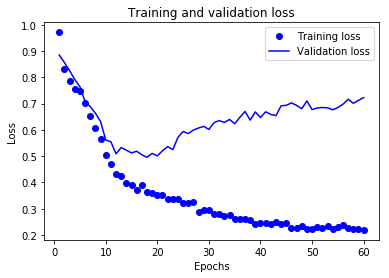

In [73]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

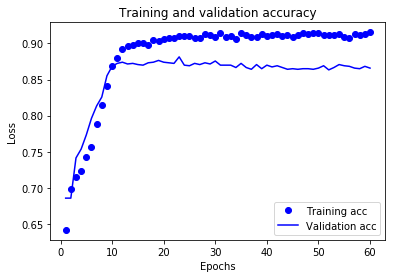

In [74]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [75]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 91.5455475995582 Epoch: 59 Best Validation Accuracy: 88.13420625833365 Epoch: 22
Lowest Training Loss value: 21.951498480755816 Epoch: 59 Lowest Validation Loss: 49.60790664786793 Epoch: 17


### 1D CNN BEST MODEL TEST RESULTS:

In [84]:
# Some memory clean-up
K.clear_session()

In [77]:
model = Sequential()       
model.add(layers.Embedding(keys+1, 128, input_length=90))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 2, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv1D(8, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [78]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [79]:
model.fit([X_train], y, verbose=0, epochs=22, 
          batch_size=128)

In [80]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

2036/2036 [==============================] - 0s 156us/step


[0.4541293900233121, 0.8659135557579385]

In [81]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [82]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.5759355210132412
F1 Score (Micro): 0.8654223968565815


/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [83]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          0       0.93      0.93      0.93      1397
          1       0.89      0.72      0.79       639

avg / total       0.92      0.87      0.89      2036



/Users/juan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## LSTM:

In [113]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 90, 128)           1119744   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 90, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 1,251,715
Trainable params: 1,251,715
Non-trainable params: 0
_________________________________________________________________


In [114]:
%%time
history = model.fit([X_train], y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Train on 4885 samples, validate on 1222 samples
Epoch 1/50
4885/4885 [==============================] - 23s 5ms/step - loss: 0.5449 - acc: 0.7656 - val_loss: 0.4311 - val_acc: 0.8290
Epoch 2/50
4885/4885 [==============================] - 23s 5ms/step - loss: 0.3478 - acc: 0.8690 - val_loss: 0.3838 - val_acc: 0.8502
Epoch 3/50
4885/4885 [==============================] - 23s 5ms/step - loss: 0.2470 - acc: 0.9116 - val_loss: 0.3596 - val_acc: 0.8543
Epoch 4/50
4885/4885 [==============================] - 25s 5ms/step - loss: 0.1807 - acc: 0.9353 - val_loss: 0.3448 - val_acc: 0.8773
Epoch 5/50
4885/4885 [==============================] - 24s 5ms/step - loss: 0.1354 - acc: 0.9533 - val_loss: 0.3457 - val_acc: 0.8789
Epoch 6/50
4885/4885 [==============================] - 24s 5ms/step - loss: 0.0950 - acc: 0.9728 - val_loss: 0.3966 - val_acc: 0.8650
Epoch 7/50
4885/4885 [==============================] - 23s 5ms/step - loss: 0.0743 - acc: 0.9783 - val_loss: 0.4231 - val_acc: 0.8797
Epoch 8

In [115]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

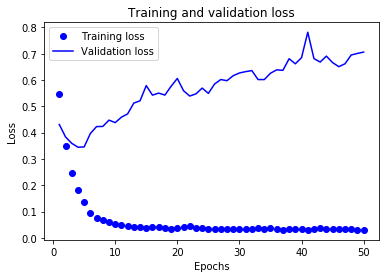

In [116]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

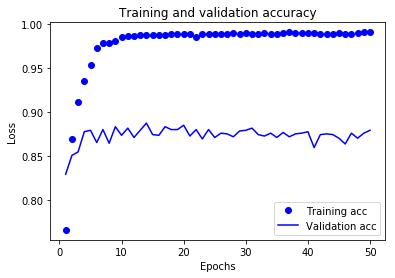

In [117]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [118]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 99.03787103377687 Epoch: 36 Best Validation Accuracy: 88.70703765296312 Epoch: 13
Lowest Training Loss value: 3.0540876469156393 Epoch: 49 Lowest Validation Loss: 34.475575258220665 Epoch: 3


### LSTM BEST MODEL TEST RESULTS:

In [127]:
# Some memory clean-up
K.clear_session()

In [120]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [121]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [122]:
model.fit([X_train], y, verbose=0, epochs=13, 
          batch_size=32)

In [123]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

2036/2036 [==============================] - 3s 1ms/step


[0.5988891250609415, 0.8777013751284781]

In [124]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [125]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.7323719442783044
F1 Score (Micro): 0.8772102161100196


In [126]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.37      0.59      0.46        78
          0       0.94      0.93      0.93      1415
          1       0.83      0.79      0.81       543

avg / total       0.89      0.88      0.88      2036



## GRU RNN:

In [145]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(GRU(128, dropout=0.2, return_sequences=True)) 
model.add(GRU(128, dropout=0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 128)           1119744   
_________________________________________________________________
gru_1 (GRU)                  (None, 90, 128)           98688     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 1,317,507
Trainable params: 1,317,507
Non-trainable params: 0
_________________________________________________________________


In [146]:
%%time
history = model.fit([X_train], y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Train on 4885 samples, validate on 1222 samples
Epoch 1/50
4885/4885 [==============================] - 31s 6ms/step - loss: 0.4675 - acc: 0.8020 - val_loss: 0.3736 - val_acc: 0.8552
Epoch 2/50
4885/4885 [==============================] - 30s 6ms/step - loss: 0.2498 - acc: 0.9140 - val_loss: 0.3457 - val_acc: 0.8682
Epoch 3/50
4885/4885 [==============================] - 29s 6ms/step - loss: 0.1284 - acc: 0.9589 - val_loss: 0.4254 - val_acc: 0.8723
Epoch 4/50
4885/4885 [==============================] - 28s 6ms/step - loss: 0.0764 - acc: 0.9771 - val_loss: 0.4599 - val_acc: 0.8764
Epoch 5/50
4885/4885 [==============================] - 28s 6ms/step - loss: 0.0540 - acc: 0.9826 - val_loss: 0.5129 - val_acc: 0.8773
Epoch 6/50
4885/4885 [==============================] - 29s 6ms/step - loss: 0.0511 - acc: 0.9846 - val_loss: 0.5408 - val_acc: 0.8625
Epoch 7/50
4885/4885 [==============================] - 28s 6ms/step - loss: 0.0497 - acc: 0.9840 - val_loss: 0.5775 - val_acc: 0.8699
Epoch 8

In [147]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

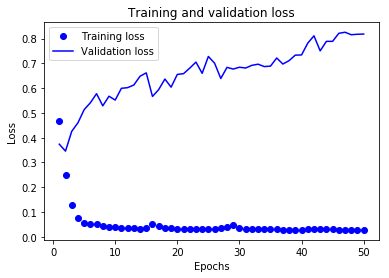

In [148]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

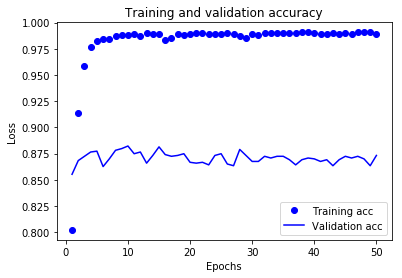

In [149]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [150]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 99.07881269313418 Epoch: 48 Best Validation Accuracy: 88.21603928962432 Epoch: 9
Lowest Training Loss value: 2.7596392228383433 Epoch: 48 Lowest Validation Loss: 34.56887536470317 Epoch: 1


### GRU RNN BEST MODEL TEST RESULTS:

In [159]:
# Some memory clean-up
K.clear_session()

In [152]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(GRU(128, dropout=0.2, return_sequences=True)) 
model.add(GRU(128, dropout=0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [153]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [154]:
%%time
model.fit([X_train], y, verbose=0, epochs=9, 
          batch_size=32)

CPU times: user 16min 32s, sys: 3min 30s, total: 20min 2s
Wall time: 5min 9s


In [155]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

2036/2036 [==============================] - 3s 1ms/step


[0.6200723410355319, 0.8796660115536163]

In [156]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [157]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.743504851565413
F1 Score (Micro): 0.8791748526522594


In [158]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.41      0.58      0.48        88
          0       0.94      0.93      0.93      1414
          1       0.83      0.81      0.82       534

avg / total       0.89      0.88      0.88      2036



## BiLSTM:

In [177]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 90, 128)           1119744   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,218,947
Trainable params: 1,218,947
Non-trainable params: 0
_________________________________________________________________


In [178]:
%%time
history = model.fit([X_train], y,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Train on 4885 samples, validate on 1222 samples
Epoch 1/50
4885/4885 [==============================] - 20s 4ms/step - loss: 0.5363 - acc: 0.7840 - val_loss: 0.4041 - val_acc: 0.8380
Epoch 2/50
4885/4885 [==============================] - 19s 4ms/step - loss: 0.2921 - acc: 0.8979 - val_loss: 0.3560 - val_acc: 0.8691
Epoch 3/50
4885/4885 [==============================] - 19s 4ms/step - loss: 0.1825 - acc: 0.9333 - val_loss: 0.3727 - val_acc: 0.8592
Epoch 4/50
4885/4885 [==============================] - 18s 4ms/step - loss: 0.1229 - acc: 0.9625 - val_loss: 0.4089 - val_acc: 0.8764
Epoch 5/50
4885/4885 [==============================] - 18s 4ms/step - loss: 0.0750 - acc: 0.9791 - val_loss: 0.4242 - val_acc: 0.8756
Epoch 6/50
4885/4885 [==============================] - 18s 4ms/step - loss: 0.0637 - acc: 0.9834 - val_loss: 0.4599 - val_acc: 0.8707
Epoch 7/50
4885/4885 [==============================] - 18s 4ms/step - loss: 0.0528 - acc: 0.9857 - val_loss: 0.4661 - val_acc: 0.8756
Epoch 8

In [179]:
# Plotting Loss & Accuracy
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

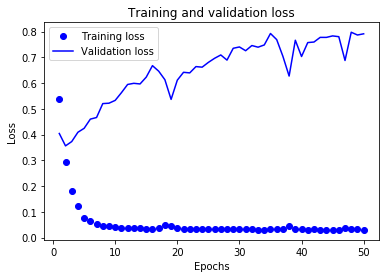

In [180]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

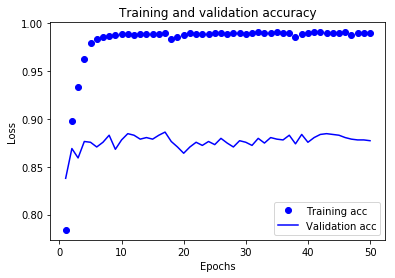

In [181]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [182]:
print('Best Training Accuracy:', max(acc)*100, 'Epoch:', np.argmax(acc),
     'Best Validation Accuracy:', max(val_acc)*100, 'Epoch:', np.argmax(val_acc))
print('Lowest Training Loss value:', min(loss)*100, 'Epoch:', np.argmin(loss),
     'Lowest Validation Loss:', min(val_loss)*100, 'Epoch:', np.argmin(val_loss))

Best Training Accuracy: 99.05834186284544 Epoch: 41 Best Validation Accuracy: 88.62520459240665 Epoch: 16
Lowest Training Loss value: 2.957029398721371 Epoch: 45 Lowest Validation Loss: 35.59880167392194 Epoch: 1


### BiLSTM BEST MODEL TEST RESULTS:

In [183]:
# Some memory clean-up
K.clear_session()

In [184]:
model = Sequential()
model.add(Embedding(keys+1, 128, input_length=90))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [185]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [186]:
%%time
model.fit([X_train], y, verbose=0, epochs=16, 
          batch_size=32)

CPU times: user 22min 40s, sys: 3min 56s, total: 26min 37s
Wall time: 5min 25s


In [187]:
model.evaluate(X_test, to_categorical(y_test.as_matrix()+1))

2036/2036 [==============================] - 2s 790us/step


[0.640946771517718, 0.8693516701752638]

In [188]:
y_train.as_matrix()+1
y_ = model.predict(X_test)
y_[-1] = [0,0,1]

In [189]:
f_macro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='macro')
f_micro = f1_score(to_categorical([np.argmax(x) for x in y_]), to_categorical(y_test.as_matrix()+1), average='micro')
print('F1 Score (Macro):', f_macro)
print('F1 Score (Micro):', f_micro)

F1 Score (Macro): 0.7178993528120009
F1 Score (Micro): 0.868860510805501


In [190]:
target_names = ['-1', '0', '1']
report = classification_report(to_categorical([np.argmax(x) for x in y_]), 
                               to_categorical(y_test.as_matrix()+1), target_names=target_names)
print(report)

             precision    recall  f1-score   support

         -1       0.31      0.70      0.43        56
          0       0.95      0.90      0.92      1473
          1       0.79      0.81      0.80       507

avg / total       0.89      0.87      0.88      2036

